# Using VADER to perform simple sentiment analysis

In [1]:
%store -r reddit_df
reddit_df = reddit_df

import pandas as pd

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
senti_analyzer = SentimentIntensityAnalyzer()

In [3]:
reddit_df["full_text"] = reddit_df["title"] + "\n" + reddit_df["content"]

In [4]:
def get_sentiment_scores(text):
    if pd.isna(text) or text == '':
        return {'neg': 0, 'neu': 0, 'pos': 0, 'compound': 0}
    return senti_analyzer.polarity_scores(text)

sentiment_scores = reddit_df['full_text'].apply(lambda x: get_sentiment_scores(x))


In [5]:
reddit_df["compound"] = sentiment_scores.apply(lambda x: x["compound"])
reddit_df["positive"] = sentiment_scores.apply(lambda x: x["pos"])
reddit_df["negative"] = sentiment_scores.apply(lambda x: x["neg"])
reddit_df["neutral"] = sentiment_scores.apply(lambda x: x["neu"])

In [6]:
reddit_df["year"] = reddit_df["date"].dt.year

In [7]:
def assign_covid_period(date):
    if date < pd.Timestamp("2020-03-01"):
        return "Pre-COVID"
    elif date >= pd.Timestamp("2020-03-01") and date < pd.Timestamp("2023-05-01"):
        return "During COVID"
    else:
        return "Post-COVID"
    
reddit_df["covid_period"] = reddit_df["date"].apply(assign_covid_period)

In [8]:
yearly_sentiment = reddit_df.groupby('year').agg({
    'compound': 'mean',
    'positive': 'mean',
    'negative': 'mean',
    'neutral': 'mean'
}).round(4)

print("Average Sentiment Scores by Year")
print(yearly_sentiment)

Average Sentiment Scores by Year
      compound  positive  negative  neutral
year                                       
2020   -0.1997    0.1113    0.1775   0.7112
2021   -0.1710    0.0979    0.1558   0.7463
2022   -0.1965    0.1066    0.1556   0.7378
2023   -0.2497    0.1114    0.1573   0.7313
2024   -0.2382    0.1056    0.1620   0.7324
2025   -0.2772    0.1026    0.1616   0.7358


In [9]:
# Group by COVID period
period_statement = reddit_df.groupby('covid_period').agg({
    'compound': ['mean', 'std', 'count'],
    'negative': 'mean',
    'positive': 'mean'
}).round(4)

print("Sentiment by COVID Period")
print(period_statement)

Sentiment by COVID Period
             compound                negative positive
                 mean     std  count     mean     mean
covid_period                                          
During COVID  -0.1967  0.6350  10517   0.1624   0.1049
Post-COVID    -0.2485  0.7024   6218   0.1600   0.1073
Pre-COVID     -0.1463  0.6532    576   0.1747   0.1142


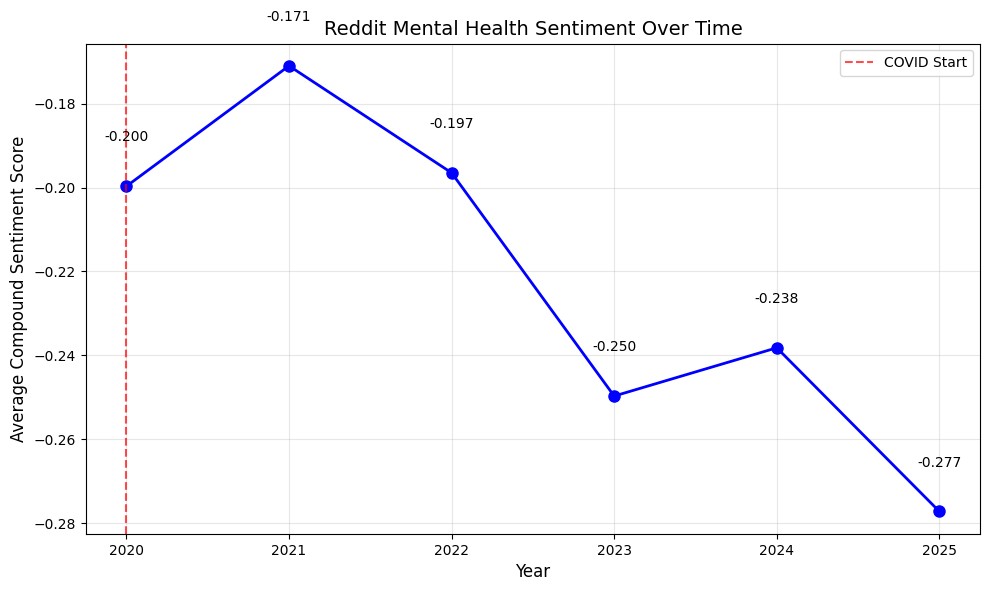

In [10]:
import matplotlib.pyplot as plt

# Create a simple line plot
plt.figure(figsize=(10, 6))

# Plot compound sentiment over years
plt.plot(yearly_sentiment.index, yearly_sentiment['compound'], 'b-o', linewidth=2, markersize=8)

# Add COVID start line
plt.axvline(x=2020, color='red', linestyle='--', alpha=0.7, label='COVID Start')

# Formatting
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Compound Sentiment Score', fontsize=12)
plt.title('Reddit Mental Health Sentiment Over Time', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# Add value labels on points
for year, score in zip(yearly_sentiment.index, yearly_sentiment['compound']):
    plt.text(year, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [11]:
# Check data distribution
print("Posts per year:")
print(reddit_df['year'].value_counts().sort_index())

# Compare pre vs during COVID (if you have that data)
print("\nAverage compound sentiment by period:")
for period in ['Pre-COVID', 'During COVID', 'Post-COVID']:
    data = reddit_df[reddit_df['covid_period'] == period]
    if len(data) > 0:
        print(f"{period}: {data['compound'].mean():.4f} (n={len(data)})")

Posts per year:
year
2020    3536
2021    3567
2022    3159
2023    2775
2024    2993
2025    1281
Name: count, dtype: int64

Average compound sentiment by period:
Pre-COVID: -0.1463 (n=576)
During COVID: -0.1967 (n=10517)
Post-COVID: -0.2485 (n=6218)


In [12]:
reddit_sent_df = reddit_df

In [13]:
%store reddit_sent_df

Stored 'reddit_sent_df' (DataFrame)
